In [1]:
! pip install pywph==1.0

Reason for being yanked: Wrong requirements.


In [2]:
import pywph as pw

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import time
import scipy.optimize as opt

In [4]:
# importing files from google drive
from google.colab import drive
drive.mount('/content/drive')

nbody = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')
mgas = np.load('drive/MyDrive/camels data/Maps_Mgas_SIMBA_LH_z=0.00.npy')

Mounted at /content/drive


In [5]:
M, N = 256, 256
J = 7
L = 8
dn = 0

nbody_data = np.log(np.copy(nbody))
mgas_data = np.log(np.copy(mgas))

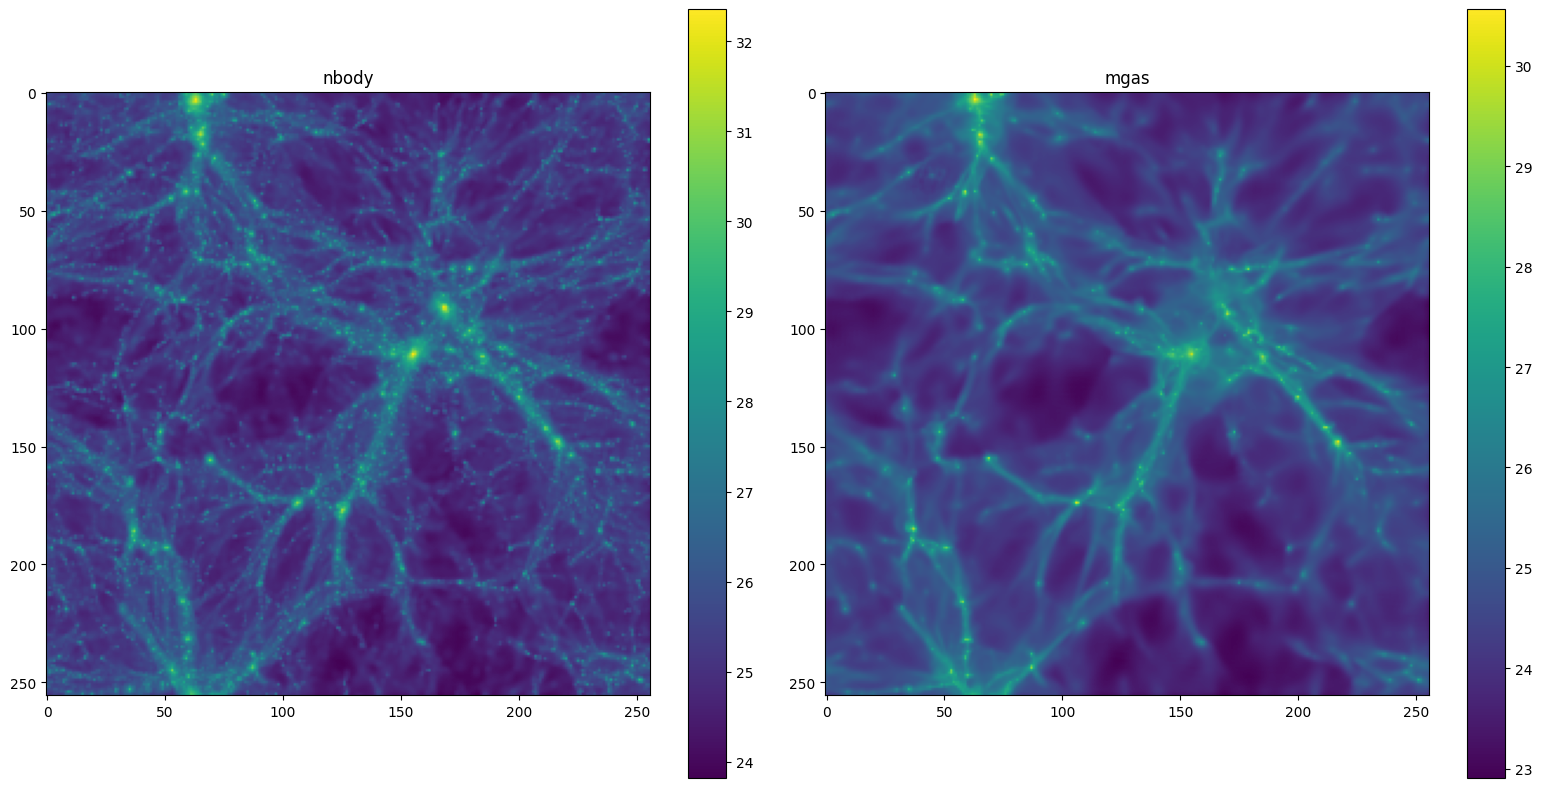

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].set_title('nbody')
axs[1].set_title('mgas')

a1 = axs[0].imshow(nbody_data[0])
fig.colorbar(a1)
a2 = axs[1].imshow(mgas_data[0])
fig.colorbar(a2)

fig.tight_layout()
fig.show()

In [7]:
device=0
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=device) # operator
wph_op.load_model(cross_moments=True)

# get joint coefficients
norm = 'auto'
coeff1 = wph_op(nbody_data[0], norm=norm, pbc=True)
coeff2 = wph_op(mgas_data[0], norm=norm, pbc=True)
coeff12 = wph_op([nbody_data[0], mgas_data[0]], cross=True, norm=norm, pbc=True)
coeff21 = wph_op([mgas_data[0], nbody_data[0]], cross=True, norm=norm, pbc=True)
print(coeff1.shape)

torch.Size([3264])


/usr/local/lib/python3.10/dist-packages/pywph/wph_operator.py:774: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 -= mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


In [8]:
# run on a GPU device
if torch.cuda.is_available():
    wph_op.to(device)

In [9]:
# generate a noise image as an initial guess

g1 = nbody_data[1]#np.random.normal(nbody_data.mean(), nbody_data.std(), (M, N))
g2 = 0.5*g1 + 0.15* np.random.normal(mgas_data.mean(), mgas_data.std(), (M, N))
guess = np.array([g1,g2])
print(guess.shape)

(2, 256, 256)


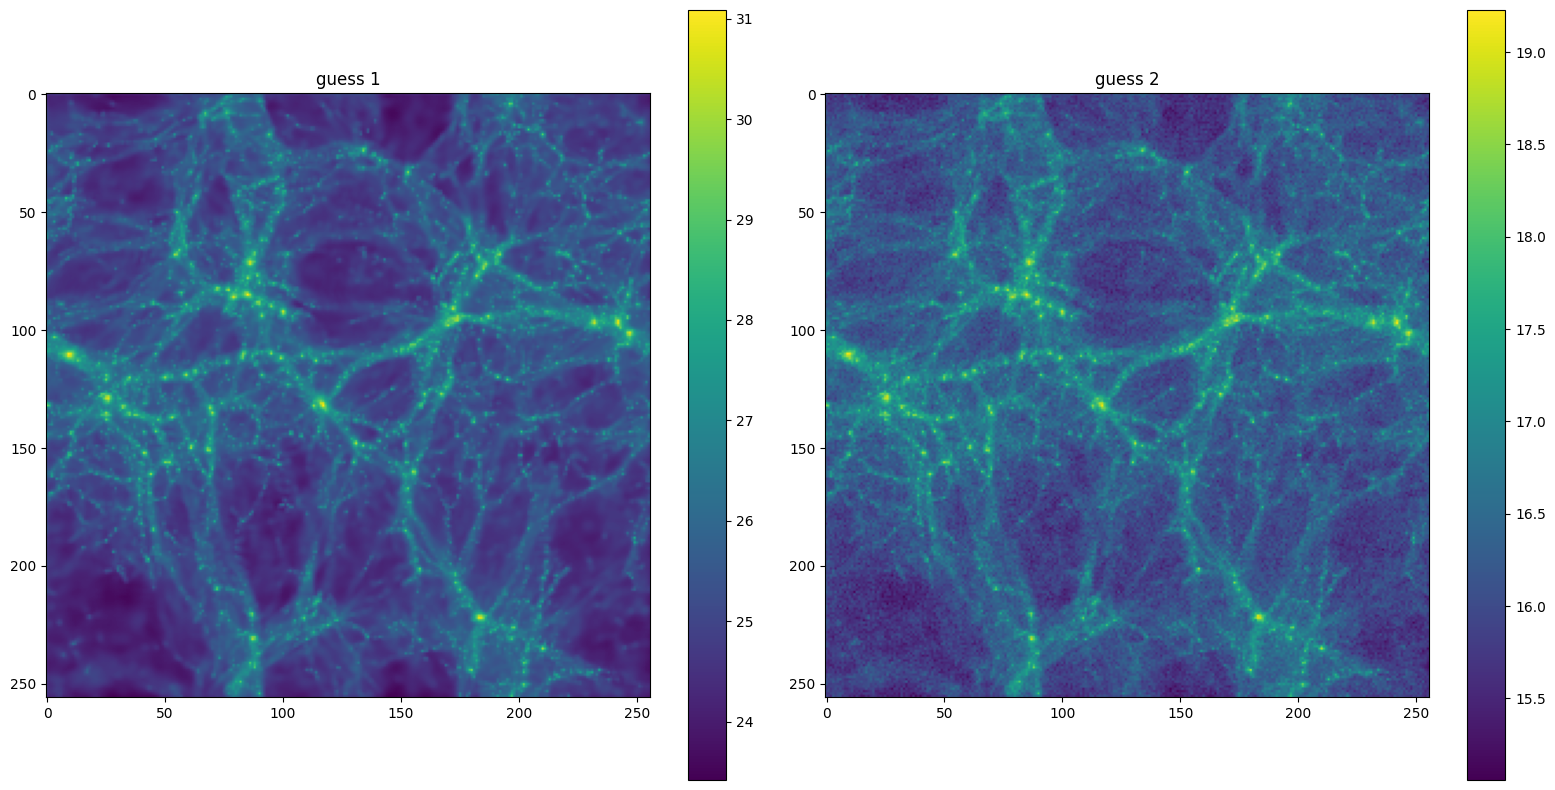

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].set_title('guess 1')
axs[1].set_title('guess 2')

a1 = axs[0].imshow(g1, interpolation=None)
fig.colorbar(a1)
a2 = axs[1].imshow(g2, interpolation=None)
fig.colorbar(a2)

fig.tight_layout()
fig.show()

In [17]:
# optimizer

eval_cnt = 0
def objective1(x):

    global eval_cnt
    print(f"Evaluation: {eval_cnt}")
    start_time = time.time()
    # Reshape x
    x_curr = x.reshape((2, M, N))
    x_curr = pw.to_torch(x_curr, device=device)
    x_curr.requires_grad = True
    x_curr1 = g1
    x_curr2 = x_curr[1]

    loss_tot = torch.zeros(1)

    x_curr2, nb_chunks = wph_op.preconfigure(x_curr2)
    for i in range(nb_chunks):
        coeffs_chunk, indices = wph_op.apply(x_curr2, i, norm=norm, ret_indices=True)
        loss = torch.sum(torch.abs(coeffs_chunk - coeff2[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk, indices, loss

    x_curr_couple12, nb_chunks = wph_op.preconfigure([x_curr1, x_curr2], cross=True)
    for i in range(nb_chunks):
        coeffs_chunk12, indices = wph_op.apply(x_curr_couple12, i, norm=norm, ret_indices=True, cross=True)
        loss = torch.sum(torch.abs(coeffs_chunk12 - coeff12[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk12, indices, loss

    x_curr_couple21, nb_chunks = wph_op.preconfigure([x_curr2, x_curr1], cross=True)
    for i in range(nb_chunks):
        coeffs_chunk21, indices = wph_op.apply(x_curr_couple21, i, norm=norm, ret_indices=True, cross=True)
        loss = torch.sum(torch.abs(coeffs_chunk21 - coeff21[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk21, indices, loss

    # Reshape the gradient
    x_grad = x_curr.grad.cpu().numpy().astype(x.dtype)
    print(f"Loss: {loss_tot.item()} (computed in {time.time() - start_time}s)")
    eval_cnt += 1

    return loss_tot.item(), x_grad.ravel()

In [18]:
total_start_time = time.time()
optim_params = {"maxiter": 400, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20}
result = opt.minimize(objective1, guess.ravel(), method='L-BFGS-B', jac=True, tol=None, options=optim_params)
final_loss, x_final, niter, msg = result['fun'], result['x'], result['nit'], result['message']
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")
print(f"Synthesis time: {time.time() - total_start_time}s")

x_final = x_final.reshape((2, M, N)).astype(np.float32)

Evaluation: 0
Loss: 1.0348388348665528e+18 (computed in 0.39826369285583496s)
Evaluation: 1
Loss: 1.0295793209950863e+18 (computed in 0.39229893684387207s)
Evaluation: 2
Loss: 1.0087825395920404e+18 (computed in 0.39478230476379395s)
Evaluation: 3
Loss: 9.29391615313707e+17 (computed in 0.3894338607788086s)
Evaluation: 4
Loss: 6.657754562172027e+17 (computed in 0.39205074310302734s)
Evaluation: 5
Loss: 2.6084027019349197e+17 (computed in 0.3918721675872803s)
Evaluation: 6
Loss: 1.246610993488855e+17 (computed in 0.4061462879180908s)
Evaluation: 7
Loss: 5.524086004383744e+16 (computed in 0.3912999629974365s)
Evaluation: 8
Loss: 2.520734344885043e+16 (computed in 0.4149155616760254s)
Evaluation: 9
Loss: 1.13729928691712e+16 (computed in 0.395435094833374s)
Evaluation: 10
Loss: 5153638632652800.0 (computed in 0.39165425300598145s)
Evaluation: 11
Loss: 2331393073872896.0 (computed in 0.3994781970977783s)
Evaluation: 12
Loss: 1055343392063488.0 (computed in 0.39778900146484375s)
Evaluation:

In [19]:
print(f'Final loss is {final_loss}')
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")
print(f"Synthesis time: {time.time() - total_start_time}s")

Final loss is 263.5195007324219
Synthesis ended in 400 iterations with optimizer message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Synthesis time: 210.22937846183777s


In [20]:
final_guess = x_final
sim1 = g1
sim2 = final_guess[1]

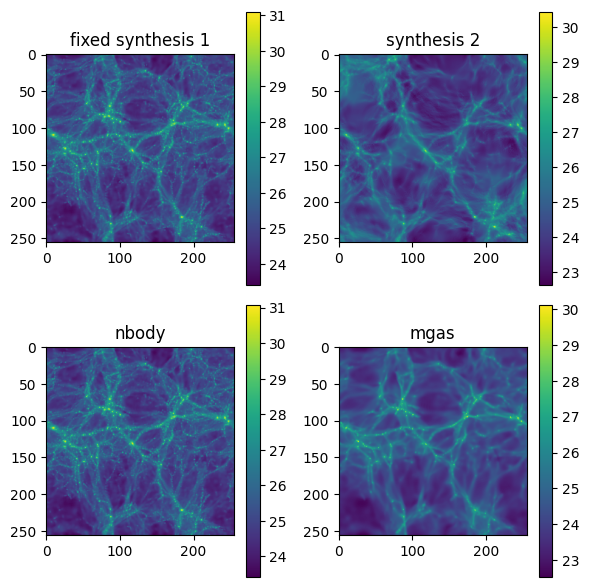

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0,0].set_title('fixed synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mgas')#######('mgas')

a1 = axs[0,0].imshow(sim1)
fig.colorbar(a1)
a2 = axs[0,1].imshow(sim2)
fig.colorbar(a2)
a3 = axs[1,0].imshow(nbody_data[1])
fig.colorbar(a3)
a4 = axs[1,1].imshow(mgas_data[1])
fig.colorbar(a4)
fig.tight_layout()
fig.show()

In [22]:
((nbody_data[1] - mgas_data[1])**2).mean()

1.0163087

In [23]:
((mgas_data[1])**2).mean()

593.99646

In [24]:
((sim2 - mgas_data[1])**2).mean()

0.6841743

In [25]:
wph1 = wph_op(sim1, ret_wph_obj=True) # WPH object
s11_guess_1 = wph1.get_coeffs("S11")[0]
wph2 = wph_op(sim2, ret_wph_obj=True)
s11_guess_2 = wph2.get_coeffs("S11")[0]

wph_nbody = wph_op(nbody_data[1], ret_wph_obj=True)
s11_nbody = wph_nbody.get_coeffs("S11")[0]

wph_mstar = wph_op(mgas_data[1], ret_wph_obj=True)
s11_mgas = wph_mstar.get_coeffs("S11")[0]

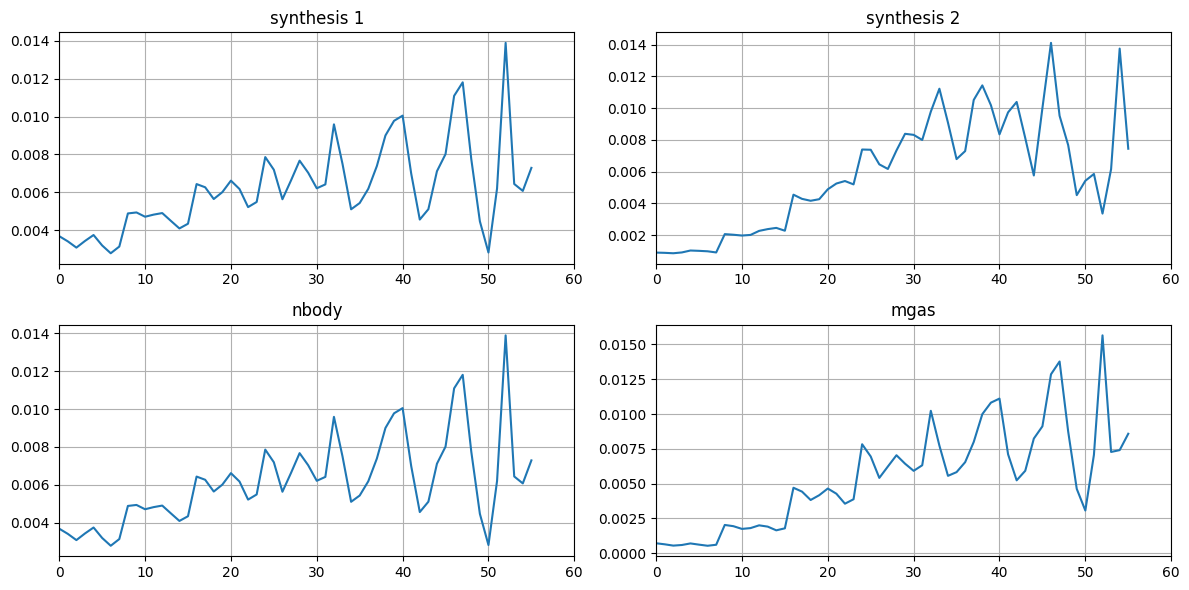

In [30]:
# compare S11 coefficients
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].plot(s11_guess_1)
axs[0,1].plot(s11_guess_2)
axs[1,0].plot(s11_nbody)
axs[1,1].plot(s11_mgas)

axs[0,0].set_title('synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mgas')

for i in range(2):
    for j in range(2):
      axs[i,j].set_xlim(0,60)
      #axs[i,j].set_ylim(0,0.02)
      axs[i,j].grid()


fig.tight_layout()
fig.show()

In [27]:
wph1 = wph_op(sim1, ret_wph_obj=True) # WPH object
s10_guess_1 = wph1.get_coeffs("S10")[0]
wph2 = wph_op(sim2, ret_wph_obj=True)
s10_guess_2 = wph2.get_coeffs("S10")[0]

wph_nbody = wph_op(nbody_data[1], ret_wph_obj=True)
s10_nbody = wph_nbody.get_coeffs("S10")[0]

wph_mstar = wph_op(mgas_data[1], ret_wph_obj=True)
s10_mgas = wph_mstar.get_coeffs("S10")[0]

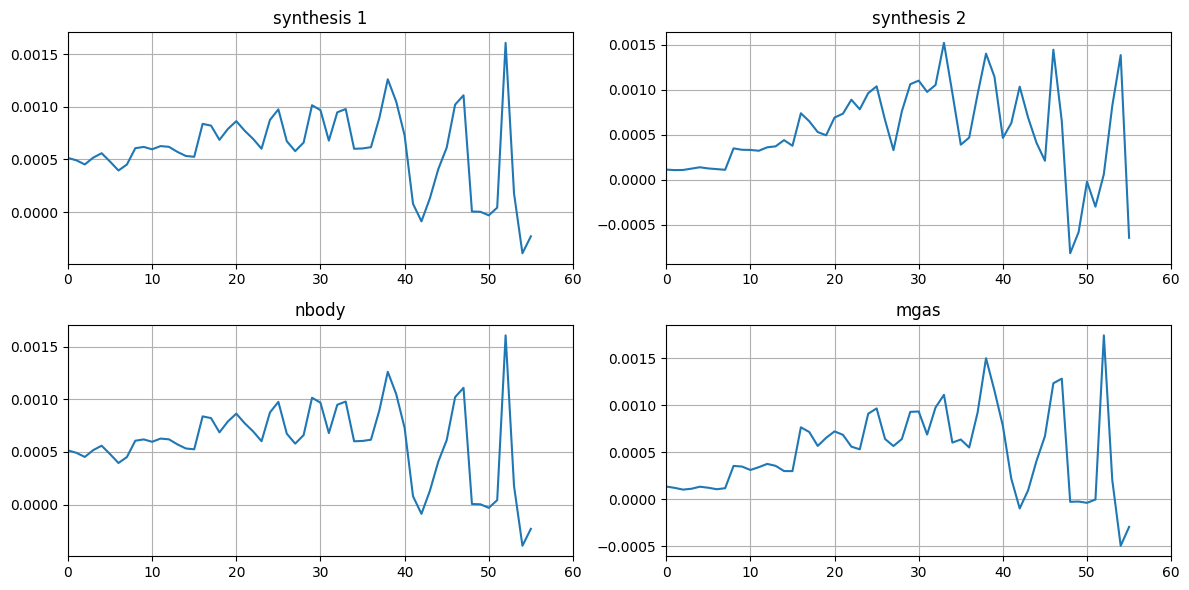

In [29]:
# compare S10 coefficients
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].plot(s10_guess_1)
axs[0,1].plot(s10_guess_2)
axs[1,0].plot(s10_nbody)
axs[1,1].plot(s10_mgas)

axs[0,0].set_title('synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mgas')

for i in range(2):
    for j in range(2):
      axs[i,j].set_xlim(0,60)
      #axs[i,j].set_ylim(0,0.0017)
      axs[i,j].grid()


fig.tight_layout()
fig.show()